# SimIM Instrument Modeling Demonstration
``simim``'s instrument module is designed to create model instruments and use these models to simulated the maps and/or timestreams that the instrument might observe. This workbook walks through the basics of constructing an instrument and generating a simple map showing the instrument's response to the sky, as well as a timestream that provides a more realistic representation of the data in the format natively produced by a detector or set of detectors.

In [1]:
# Import some standard libraries:
import numpy as np
import matplotlib.pyplot as plt

## Creating a sky
We'll start by creating a sky, which for our purposes will contain a single point source emmitting a flat continuum. To do this, we will need the ``simim.map`` package.

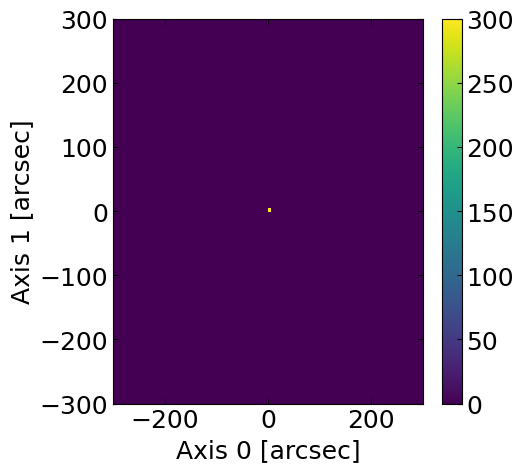

In [2]:
import simim.map as map

# We'll create a map covering 85-115 GHz 
# with 600"x600" dimensions.
center = [0,0,90]
sides = [600,600,30]
axunits = ['arcsec','arcsec','GHz']
gridunits = 'Jy'

# We'll use pixels of 3"x3"x100MHz
pixel_size = (6,6,.1)

# Generate an empty grid:
field = map.Gridder([],[],setndims=3,center_point=center,side_length=sides,axunits=axunits,gridunits=gridunits,pixel_size=pixel_size)

# Create a 1 Jy point source somewhere in the map
field.grid[50,50,:,0] = 1

# Show the result
field.visualize()

## Creating a detector
Next we define a detector object. This is handled by the ``simim.instrument`` package and specifically the ``detector`` class. Start by simulating a single detector with a boxcar spectral response centered at 100 GHz. We'll couple that detector to a 12M diameter telescope. The ``simim.instrument`` has built in functions for handling simple point spread functions and spectral responses. We'll use these to start, but later we can define more sophisticated functions to create realistic detector responses.

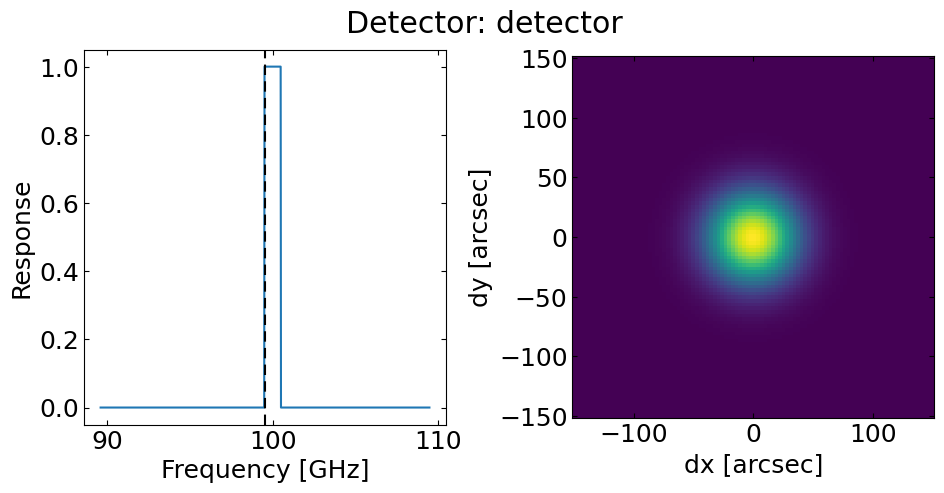

In [7]:
import simim.instrument as inst

f0 = 100 # GHz
channel_width = 1 # GHz
spectral_unit = 'GHz'
dish_diameter = 12 # m
fwhm = 1.2 * (2.998e8/(f0*1e9)) / dish_diameter * 180/np.pi * 3600 # 1.2 lambda/D, converted to arcsec
spatial_unit = 'arcsec'

# Create a detector object. The spatial response (ie PSF) is a Gaussain
# with the FWHM we calculated for 230 GHz, and varrying as a function of
# frequency as FWHM \propto 100GHz/nu. This is implemented as the 'spec-gauss'
# spatial response function in the detector initialization. The parameters
# of the function (fwhmx, fwhmy, freq0) can be specified using the 
# spatial_kwargs parameter.
# The spectral response is a boxcar, implemented as the 'boxcar' spectral
# response function. Again the parameters of this function (freq0, width)
# can be specified using the spectral_kwargs parameter.
simple_detector = inst.Detector(spatial_response='spec-gauss',
                                spatial_kwargs={'fwhmx':fwhm,'fwhmy':fwhm,'freq0':f0},
                                spatial_unit=spatial_unit,
                                spectral_response='boxcar',
                                spectral_kwargs={'freq0':f0,'width':channel_width},
                                spectral_unit=spectral_unit,
                                noise_function='none',
                                )

# We can now visualize this detector's response functions:
simple_detector.plot_detector_response(xmin=-150,xmax=150,ymin=-150,ymax=150)#fmin=85,fmax=115,fspatial=100,


Next we can assign a field for our detector to observe - in this case the grid we defined before. And use our detector instance to create a 2D map showing the sky as our instrument would see it.

/Users/keenan/Dropbox/4_research/2.0_simim/simim/instrument/_helpers.py:89: UserWarning: Detector unit for flux not specified. Assuming it matches grid unit
  warnings.warn("Detector unit for flux not specified. Assuming it matches grid unit")


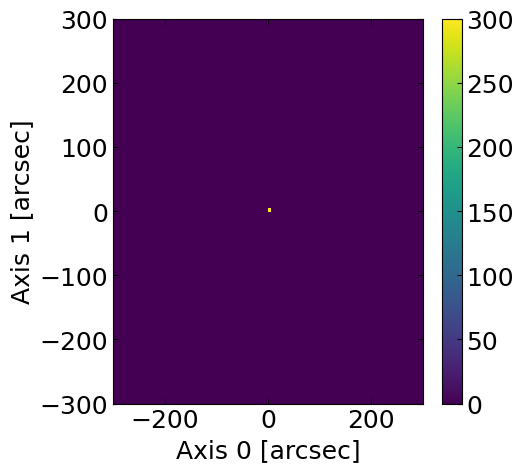

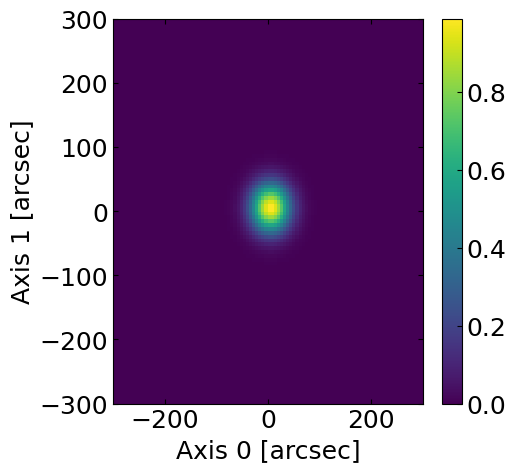

In [21]:
### If you've run the cell before uncomment the next line:
# simple_detector.del_fields('field0') 

simple_detector.add_field(field,'field0',field_property_idx=0)
simple_detector.map_fields(kernel_size=(200,200),pad=0,spatial_response_norm='none')
field.visualize()
simple_detector.maps['field0'].visualize()

## Creating a Timestream
Finally, we can define a time-ordered series of telescope pointings
and use this to extract the time series (of pure signal) that would 
be measured by our detectors. We'll define a simple raster scan across
the map.

In [23]:
x0 = -200
y0 = -200
dx = .1
dy = 6
lx = 400

nsamples = 320000
x_series = x0 + (np.arange(nsamples)*dx) % (lx)
x_series[((np.arange(nsamples)*dx) // (lx))%2==1] = -x_series[((np.arange(nsamples)*dx) // (lx))%2==1]
y_series = y0 + (np.arange(nsamples)*dx // lx)*dy
plt.plot(x_series,y_series)


The resulting time series can be extracted using the ``detector.sample``
method. Plotting the time series will show a series of increasing the 
decreasing peaks as telescope passes over the source.

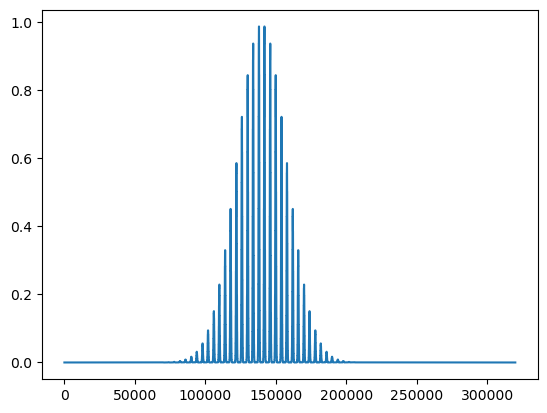

In [28]:
position_series = np.stack((x_series,y_series)).T
values = simple_detector.sample_fields(position_series, 'field0', sample_noise=False)
plt.plot(values[:,0])
plt.show()